In [ ]:
!pip install kaggle-cli
!pip install --upgrade --force-reinstall --no-deps kaggle
!apt-get install git
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!mkdir results
!mkdir results_fig_norm
!mkdir results_fig_transfer

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

api_token = {"username":"kaggle_username","key":"kaggle_key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mengcius/cinic10
!unzip -qq -n cinic10.zip

     |████████████████████████████████| 81kB 6.3MB/s 
     |████████████████████████████████| 5.3MB 17.1MB/s 
     |████████████████████████████████| 112kB 58.0MB/s 
     |████████████████████████████████| 133kB 54.7MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
  Created wheel for kaggle-cli: filename=kaggle_cli-0.12.13-cp36-none-any.whl size=9489 sha256=a8a9f3a96fa6059836c3bd8dbb8fdbe8f3b72e2a20a14239c7cb720aaac7f262
  Stored in directory: /root/.cache/pip/wheels/d5/bb/10/c1dd1b08c7433c943cb55c46367ae3f891415e8a37300ff8a7
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=a50c7c5b374db266c509338b568a8a81148395cf7ebf185e267751e4443cf5ba
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 sha256=f2b513e3f7c5e1e90cec07a7028eec01cf518e8037841476f4867e02436531c8
  Stored in directory: /root/.ca

In [ ]:
import keras
from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, Input
import os
import numpy as np
import cv2
import random
import tensorflow as tf
from sklearn.metrics import confusion_matrix

plt.rcParams["figure.figsize"] = [15,15]
address = ''

address_train = address+'train'
address_test = address+'test'
address_val = address+'valid'

classes = os.listdir(address_train)
num_classes = len(classes)

X_train, y_train, X_test, y_test, X_val, y_val = [], [], [], [], [], []

label_one_hot = [0] * num_classes
label_ct = 0

test_data_for_each_class = [[] for _ in range(num_classes)]
test_label_for_each_class = [[] for _ in range(num_classes)]

label_names = []
for label in classes:
    label_names.append(label)
    image_addr = address_train+'/'+label
    train_files = os.listdir(image_addr)
    test_files = os.listdir(image_addr)
    val_files = os.listdir(image_addr)
    label_one_hot[label_ct] = 1
    label_for_this_class = label_one_hot.copy()

    for f in train_files:
        X_train.append(cv2.normalize(cv2.imread(image_addr+'/'+f).reshape(32, 32, 3), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
        y_train.append(label_for_this_class)

    for f in test_files:
        X_test.append(cv2.normalize(cv2.imread(image_addr+'/'+f).reshape(32, 32, 3), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
        y_test.append(label_for_this_class)
        test_data_for_each_class[label_ct].append(np.array(X_test[-1]))
        test_label_for_each_class[label_ct].append(np.array(label_for_this_class))

    for f in val_files:
        X_val.append(cv2.normalize(cv2.imread(image_addr+'/'+f).reshape(32, 32, 3), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
        y_val.append(label_for_this_class)
    
    label_one_hot[label_ct] = 0
    label_ct = label_ct + 1

shuffled_indices_train = list(range(len(X_train)))
shuffled_indices_test = list(range(len(X_test)))
shuffled_indices_val = list(range(len(X_val)))

random.shuffle(shuffled_indices_train)
random.shuffle(shuffled_indices_test)
random.shuffle(shuffled_indices_val)

test_data_for_each_class = np.array(test_data_for_each_class)
test_label_for_each_class = np.array(test_label_for_each_class)

X_train, y_train = np.array([X_train[i] for i in shuffled_indices_train]), np.array([y_train[i] for i in shuffled_indices_train])
X_test, y_test = np.array([X_test[i] for i in shuffled_indices_test]), np.array([y_test[i] for i in shuffled_indices_test])
X_val, y_val = np.array([X_val[i] for i in shuffled_indices_val]), np.array([y_val[i] for i in shuffled_indices_val])

In [ ]:

input_shape = (32, 32, 3)

cm = [[] for _ in range(8)] #toplam model sayisi
counter = 0

for layer_count in [2,3]:
    for filter_count in [32]:
        for filter_len in [3,5]:
            for optimizer in ['Adam']:
                for activation in ['relu']:
                    for initializer in ['glorot_normal']:
                        for drop_rate in [0.2, 0.7]:
                            model = Sequential()
                            model.add(Input(shape=input_shape))
                            for i in range(layer_count):
                              model.add(Conv2D(filter_count, (filter_len, filter_len), activation=activation, kernel_initializer=initializer))
                              model.add(Dropout(drop_rate))
                            model.add(Flatten())
                            model.add(Dense(512, activation=activation, kernel_initializer=initializer))
                            model.add(Dropout(drop_rate))
                            model.add(Dense(num_classes, activation='softmax', kernel_initializer=initializer))
                            model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
                            model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, verbose=0)
                            model.evaluate(X_test, y_test)
                            y_pred = model.predict(X_test)
                            cm[counter] = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
                            counter = counter + 1       

2813/2813 [==============================] - 8s 3ms/step - loss: 1.7406 - accuracy: 0.3613


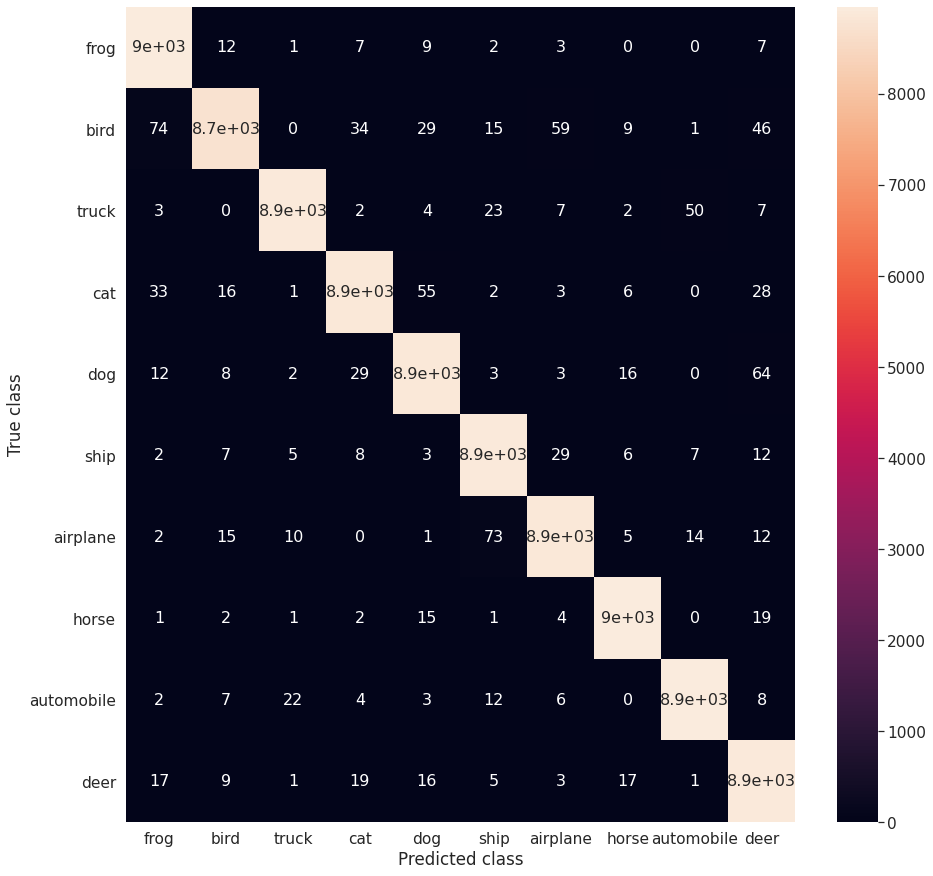

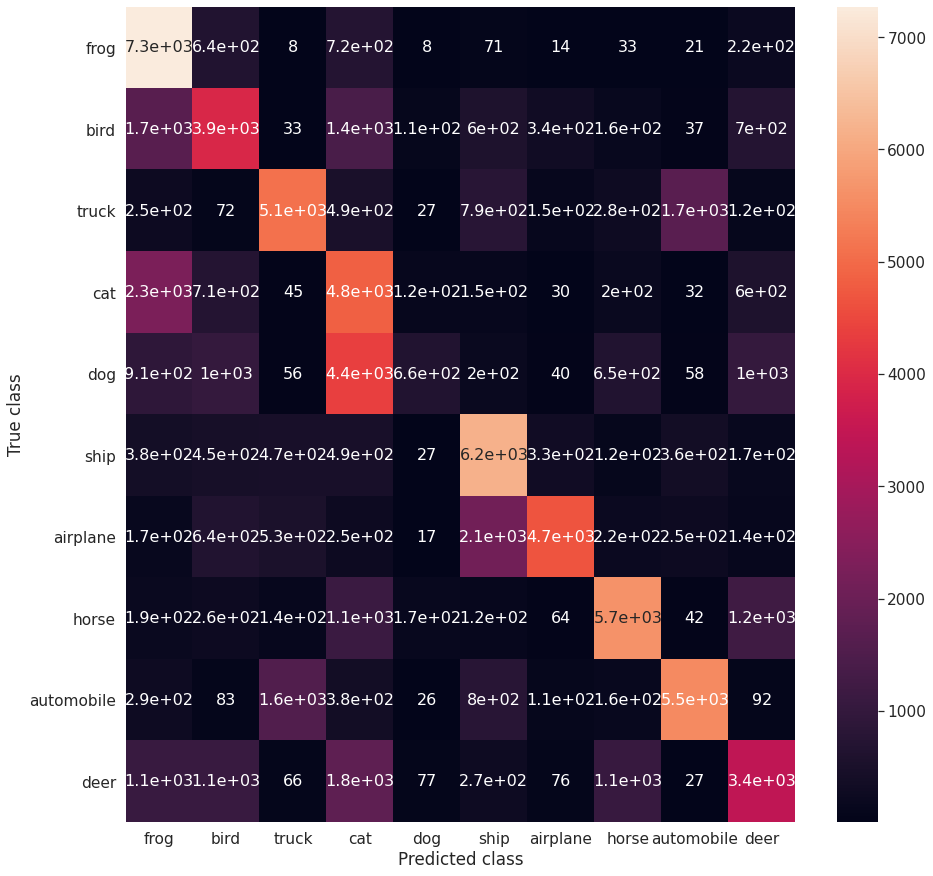

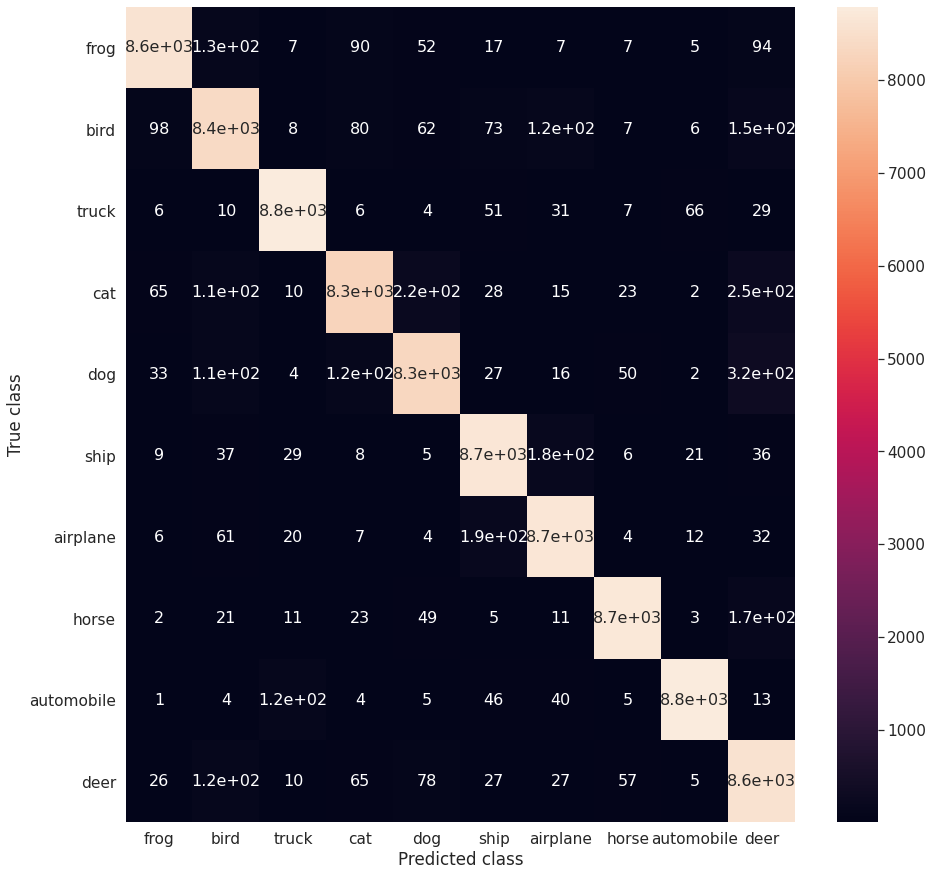

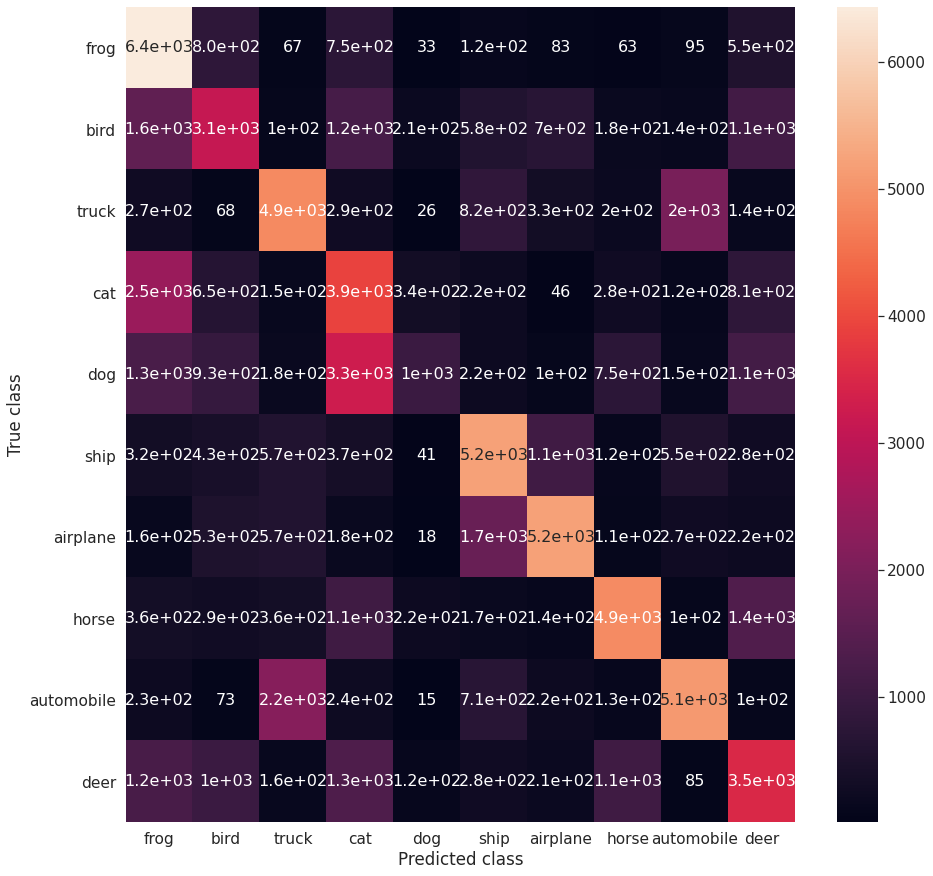

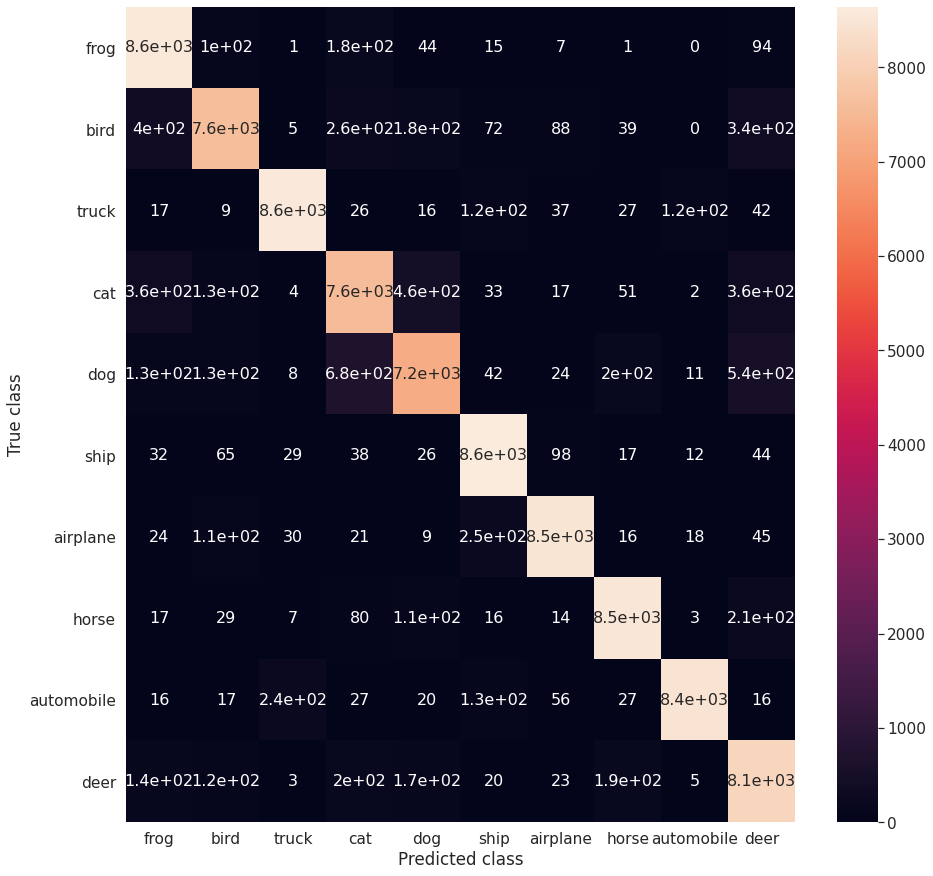

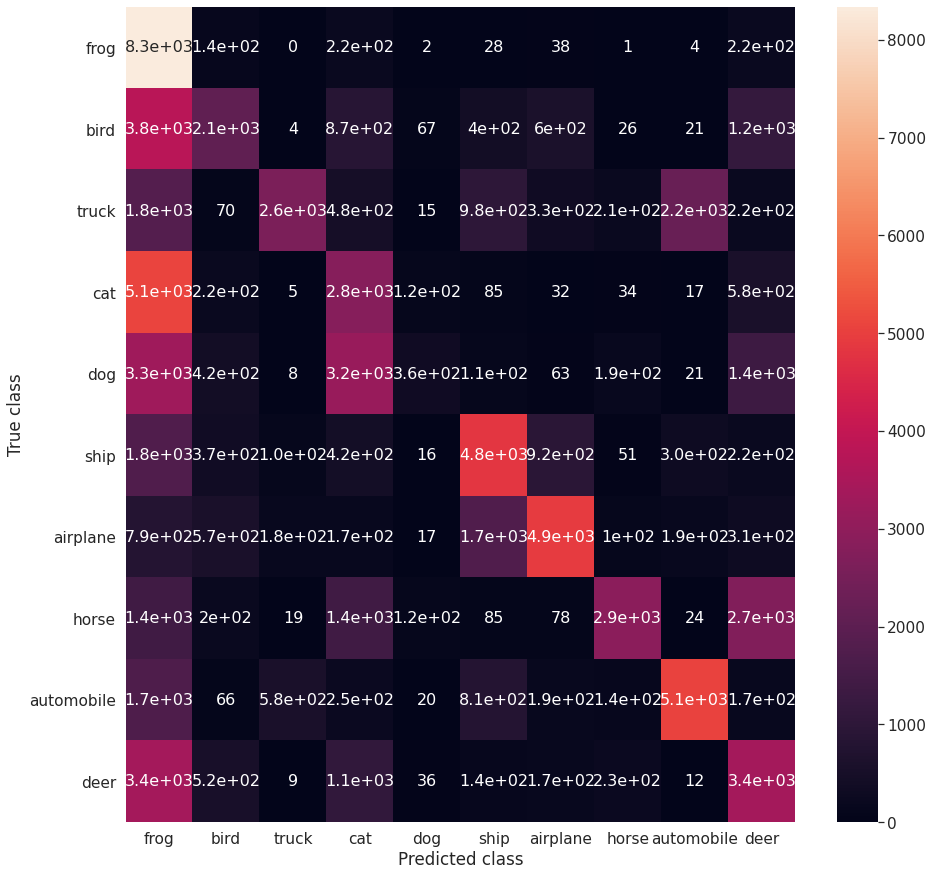

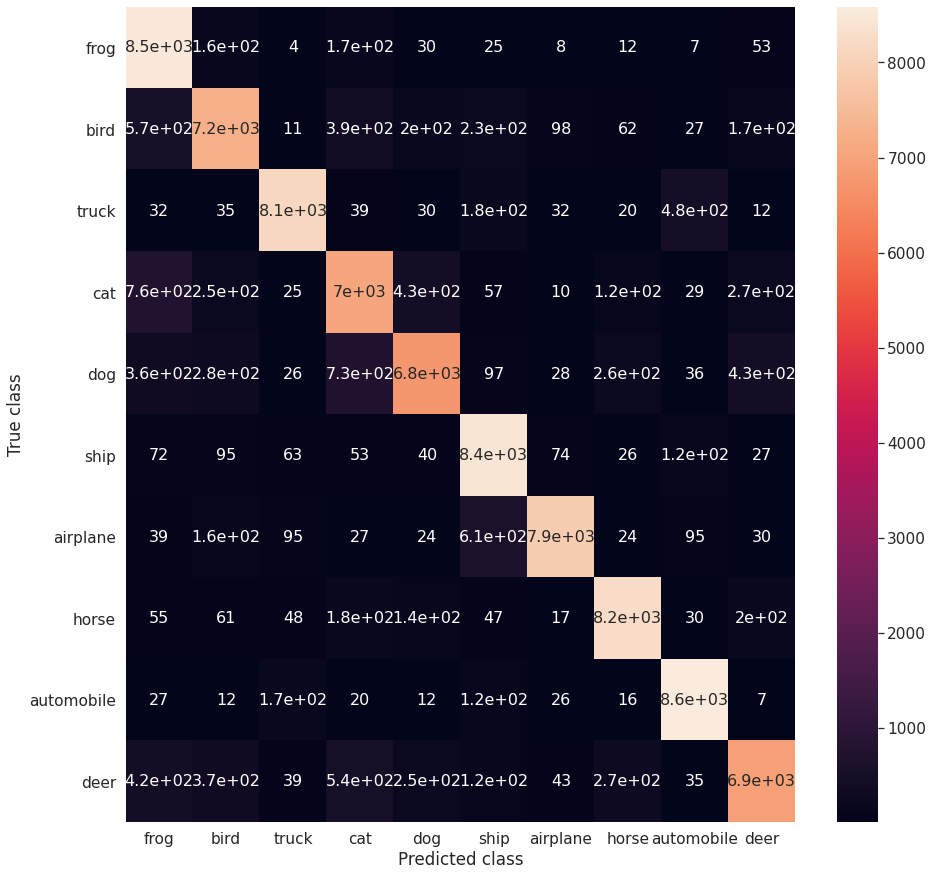

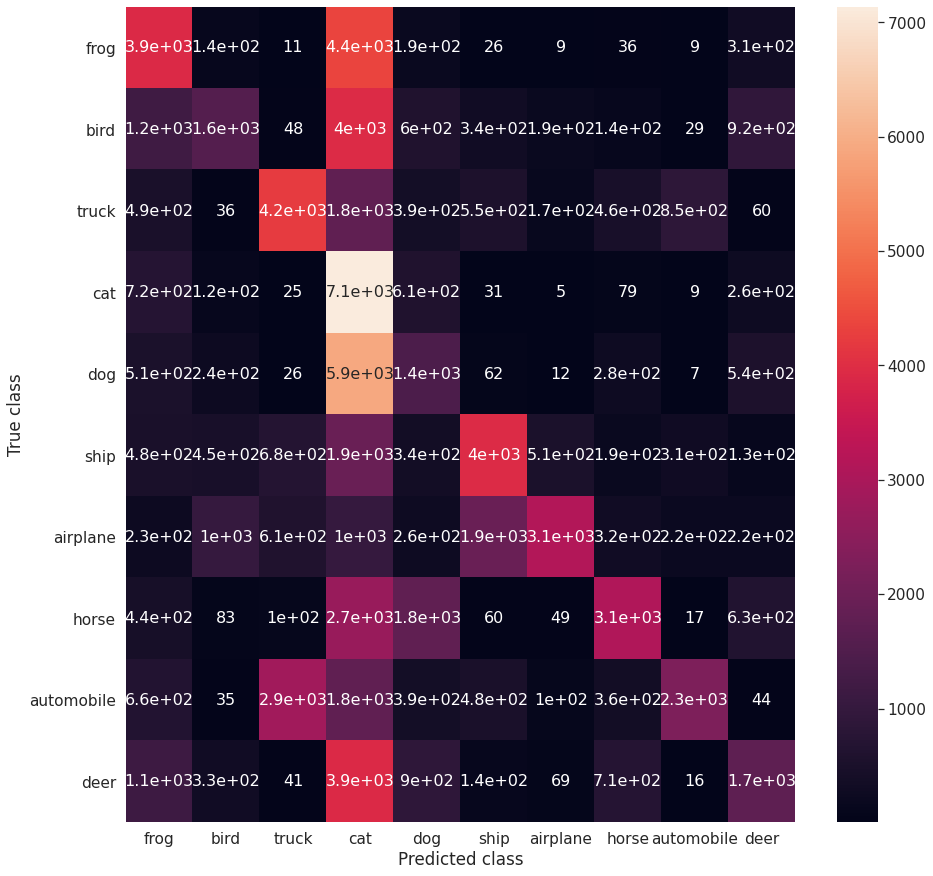

In [ ]:
for i in range(8):
    sns.set(font_scale=1.4) 
    sns.heatmap(cm[i], annot=True, annot_kws={"size": 16}, yticklabels=label_names, xticklabels=label_names)

    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.savefig('results_fig_norm/'+str(i)+'.png')
    plt.show()     

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

inputs = keras.Input(shape=(32, 32, 3))

vgg_only_one = VGG16(weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False)
for l in range(len(vgg_only_one.layers)):
  vgg_only_one.layers[l].trainable=False
vgg_only_one = vgg_only_one(inputs)
vgg_only_one = Flatten()(vgg_only_one)
#vgg_only_one = Dense(4096, activation='relu')(vgg_only_one)
#vgg_only_one = Dense(4096, activation='relu')(vgg_only_one)
vgg_only_one = Dense(1024, activation='relu')(vgg_only_one)
vgg_only_one = Dense(num_classes, activation='softmax')(vgg_only_one)
vgg_only_one = keras.Model(inputs, vgg_only_one)
vgg_only_one.summary()
vgg_only_one.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
vgg_only_one.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[keras.callbacks.EarlyStopping(patience=15)])
vgg_only_one.evaluate(X_test, y_test)

y_pred = vgg_only_one.predict(X_test)
cm_vgg_1 = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

vgg_last_four = VGG16(weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False)
for l in range(len(vgg_last_four.layers) - 1):
  vgg_last_four.layers[l].trainable=False
vgg_last_four = vgg_last_four(inputs)
vgg_last_four = Flatten()(vgg_last_four)
vgg_last_four = Dense(4096, activation='relu')(vgg_last_four)
vgg_last_four = Dense(4096, activation='relu')(vgg_last_four)
vgg_last_four = Dense(1024, activation='relu')(vgg_last_four)
vgg_last_four = Dense(num_classes, activation='softmax')(vgg_last_four)
vgg_last_four = keras.Model(inputs, vgg_last_four)
vgg_last_four.summary()
vgg_last_four.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
vgg_last_four.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[keras.callbacks.EarlyStopping(patience=15)])
vgg_last_four.evaluate(X_test, y_test)

y_pred = vgg_last_four.predict(X_test)
cm_vgg_4 = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

resnet_only_one = ResNet50(weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False)
for l in range(len(resnet_only_one.layers)):
  resnet_only_one.layers[l].trainable=False
resnet_only_one = resnet_only_one(inputs)
resnet_only_one = Flatten()(resnet_only_one)
resnet_only_one = Dense(1024, activation='relu')(resnet_only_one)
resnet_only_one = Dense(num_classes, activation='softmax')(resnet_only_one)
resnet_only_one = keras.Model(inputs, resnet_only_one)
resnet_only_one.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
resnet_only_one.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=64, callbacks=[keras.callbacks.EarlyStopping(patience=15)])
resnet_only_one.evaluate(X_test, y_test)
resnet_only_one.summary()

y_pred = resnet_only_one.predict(X_test)
cm_resnet_1 = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

resnet_last_four = ResNet50(weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False)
for l in range(len(resnet_last_four.layers) - 2):
  resnet_last_four.layers[l].trainable=False
resnet_last_four.layers[-1].trainable=True
resnet_last_four.layers[-2].trainable=True
resnet_last_four.layers[-3].trainable=True
resnet_last_four = resnet_last_four(inputs)
resnet_last_four = Flatten()(resnet_last_four)
resnet_last_four = Dense(1024, activation='relu')(resnet_last_four)
resnet_last_four = Dense(num_classes, activation='softmax')(resnet_last_four)
resnet_last_four = keras.Model(inputs, resnet_last_four)
resnet_last_four.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=3e-3), metrics=['accuracy'])
resnet_last_four.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=64, callbacks=[keras.callbacks.EarlyStopping(patience=15)])
resnet_last_four.evaluate(X_test, y_test)
resnet_last_four.summary()

y_pred = resnet_last_four.predict(X_test)
cm_resnet_4 = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                10250     
Total params: 15,250,250
Trainable params: 535,562
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/50
1407/1407 [======================

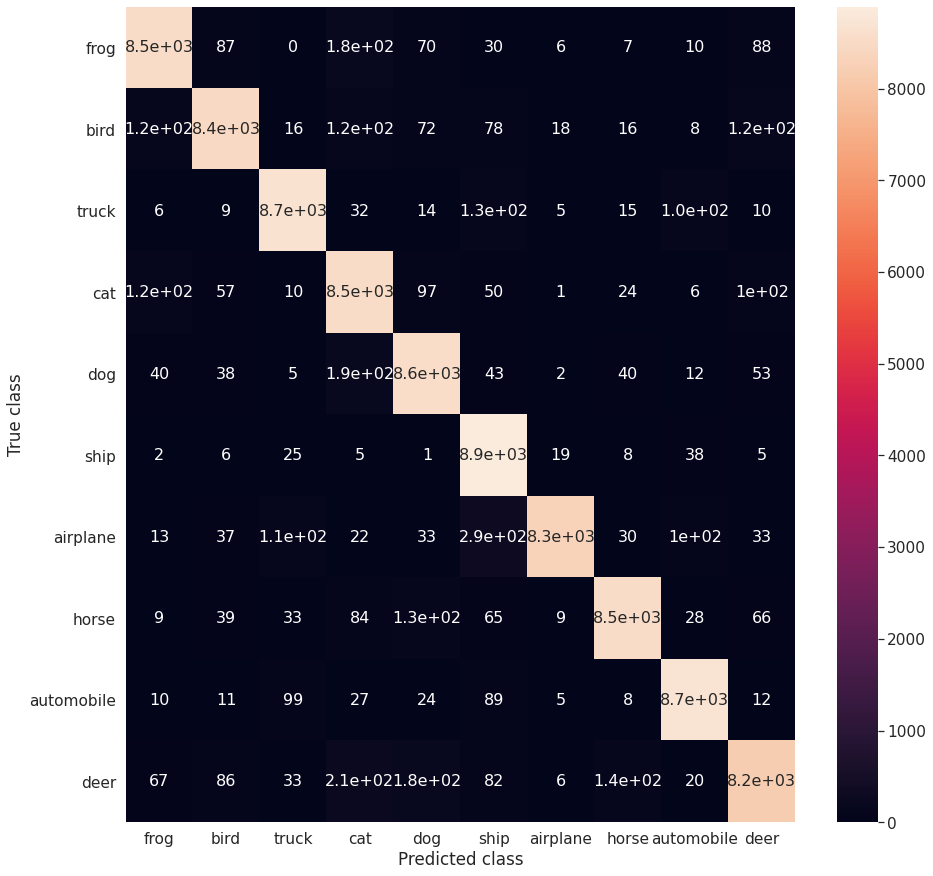

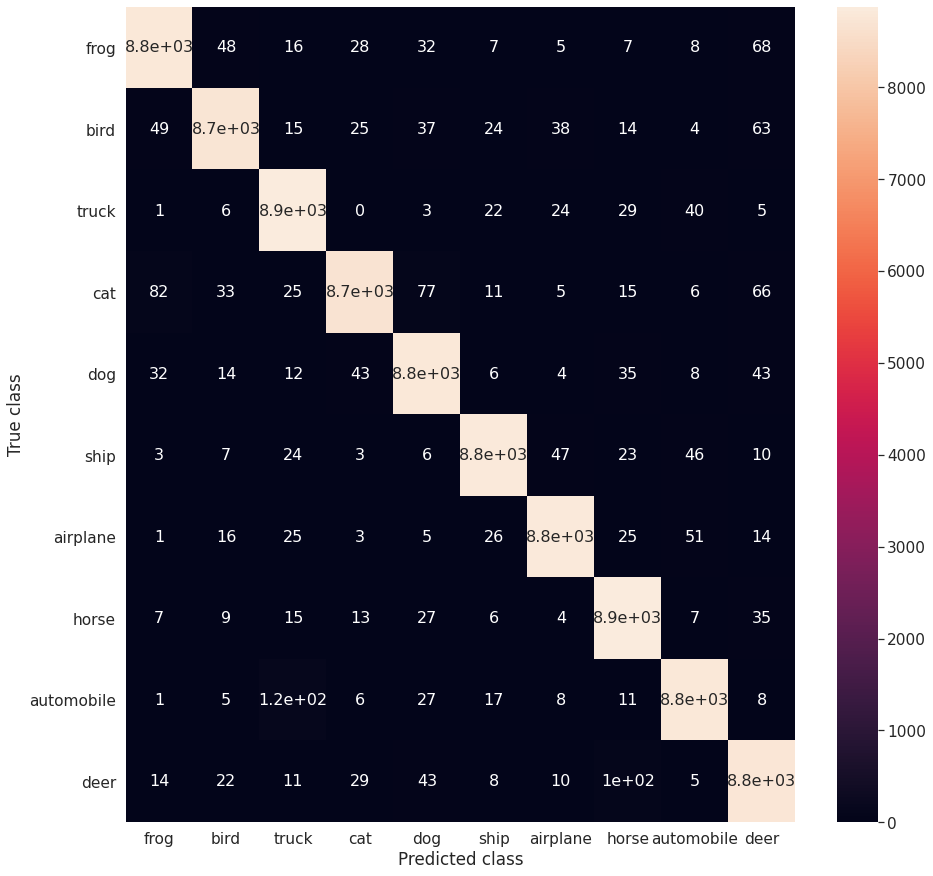

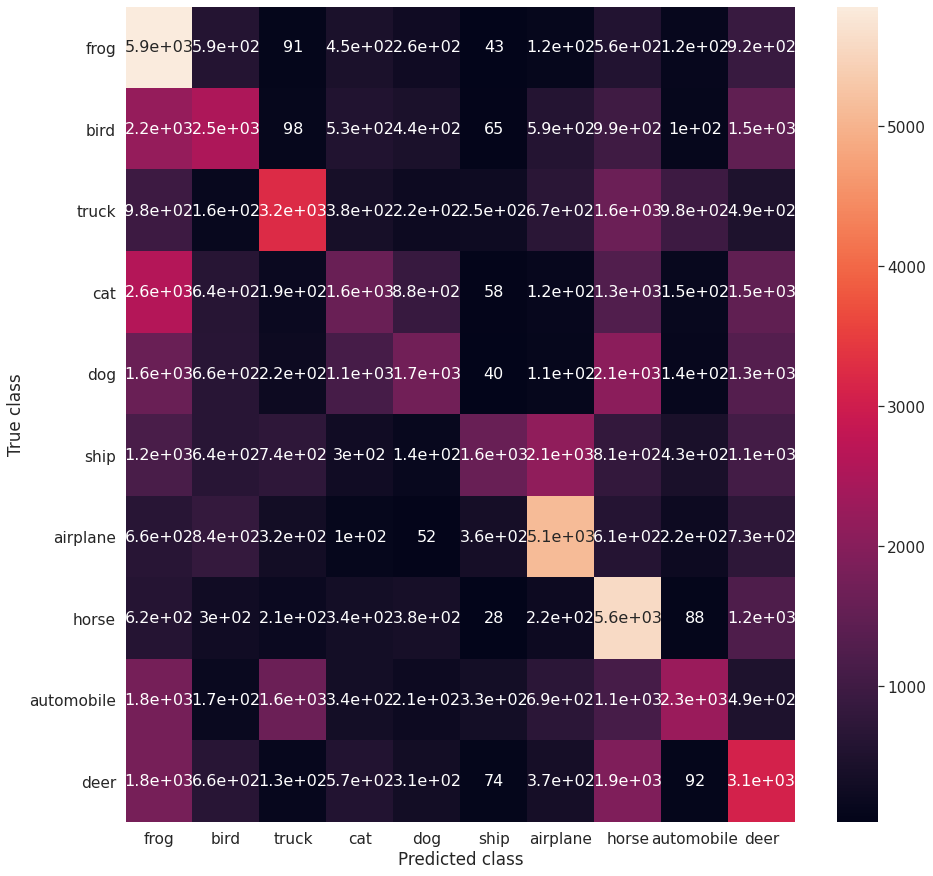

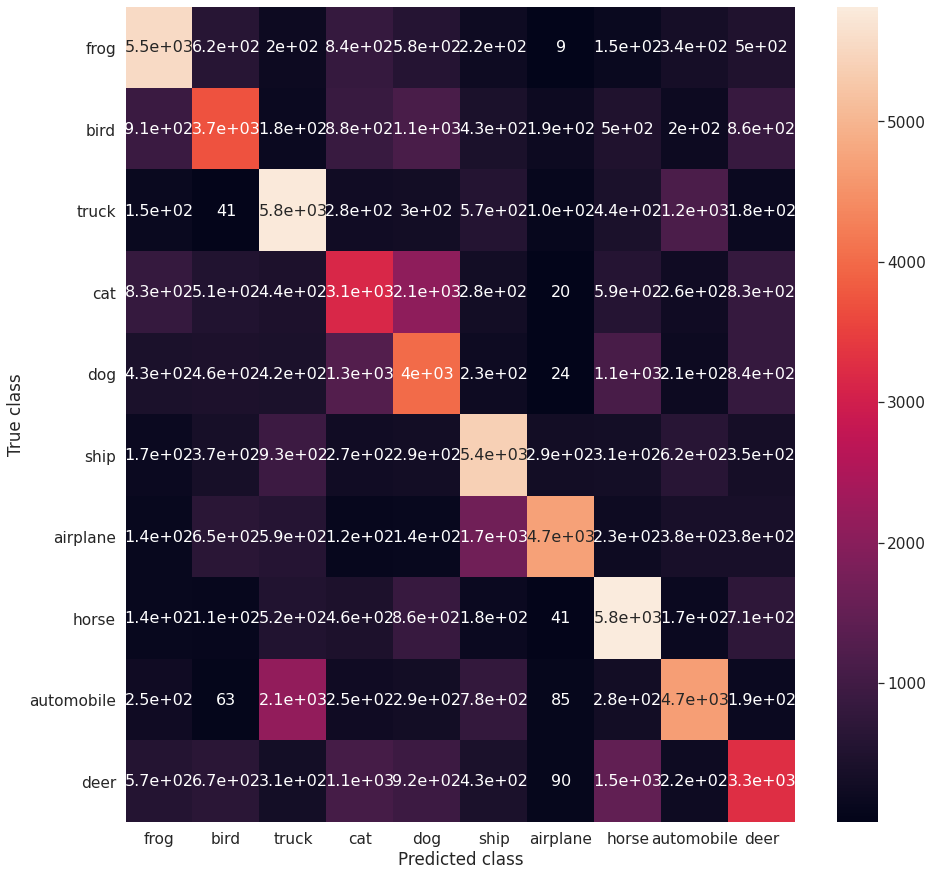

In [ ]:
sns.set(font_scale=1.4) 
sns.heatmap(cm_vgg_1, annot=True, annot_kws={"size": 16}, yticklabels=label_names, xticklabels=label_names)

plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('results_fig_transfer/vgg_1.png')
plt.show()   

sns.set(font_scale=1.4) 
sns.heatmap(cm_vgg_4, annot=True, annot_kws={"size": 16}, yticklabels=label_names, xticklabels=label_names)

plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('results_fig_transfer/vgg_4.png')
plt.show()   

sns.set(font_scale=1.4) 
sns.heatmap(cm_resnet_1, annot=True, annot_kws={"size": 16}, yticklabels=label_names, xticklabels=label_names)

plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('results_fig_transfer/resnet_1.png')
plt.show()   

sns.set(font_scale=1.4) 
sns.heatmap(cm_resnet_4, annot=True, annot_kws={"size": 16}, yticklabels=label_names, xticklabels=label_names)

plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('results_fig_transfer/resnet_4.png') 
plt.show()  

In [ ]:
from keras import backend as K
import math

get_resnet_1_last_layer_output = K.function([resnet_only_one.layers[0].input],
                                  [resnet_only_one.layers[-2].output])

get_resnet_4_last_layer_output = K.function([resnet_last_four.layers[0].input],
                                  [resnet_last_four.layers[-2].output])

get_vgg_1_last_layer_output = K.function([vgg_only_one.layers[0].input],
                                  [vgg_only_one.layers[-2].output])

get_vgg_4_last_layer_output = K.function([vgg_last_four.layers[0].input],
                                  [vgg_last_four.layers[-2].output])

last_layer_output_vgg_1 = [[] for _ in range(num_classes)]

last_layer_output_vgg_4 = [[] for _ in range(num_classes)]

last_layer_output_resnet_1 = [[] for _ in range(num_classes)]

last_layer_output_resnet_4 = [[] for _ in range(num_classes)]

cosine_test_images = [[] for _ in range(num_classes)]

for i in range(len(X_test)):
  if len(cosine_test_images[np.where(y_test[i] == 1)[0][0]]) < 3:
    last_layer_output_vgg_1[np.where(y_test[i] == 1)[0][0]].append(get_vgg_1_last_layer_output(np.array([X_test[i]]))[0])
    last_layer_output_vgg_4[np.where(y_test[i] == 1)[0][0]].append(get_vgg_4_last_layer_output(np.array([X_test[i]]))[0])

    last_layer_output_resnet_1[np.where(y_test[i] == 1)[0][0]].append(get_resnet_1_last_layer_output(np.array([X_test[i]]))[0])
    last_layer_output_resnet_4[np.where(y_test[i] == 1)[0][0]].append(get_resnet_4_last_layer_output(np.array([X_test[i]]))[0])
  
    cosine_test_images[np.where(y_test[i] == 1)[0][0]].append(X_test[i])

def write_for_different_model(array, name_prefix, ind_i, ind_j, success):
  best_images = []
  ret = success
  for i in range(len(cosine_test_images)):
    for j in range(3):
      layer_output_1 = array[i][j]
      image_similarities = []
      images = []
      for k in range(len(cosine_test_images)):
        for l in range(3):
          if k == i and l == j:
            continue
          layer_output_2 = array[k][l]
          scalar_sum = 0.0
          mag_1 = 0.0
          mag_2 = 0.0

          for t in range(len(layer_output_1[0])):
            scalar_sum = scalar_sum + layer_output_1[0][t] * layer_output_2[0][t]
            mag_1 = mag_1 + layer_output_1[0][t]**2
            mag_2 = mag_2 + layer_output_2[0][t]**2

          image_similarities.append(scalar_sum/(math.sqrt(mag_1)*math.sqrt(mag_2)))
          images.append([k,l])
      image_similarities = np.array(image_similarities)
      best_indices = image_similarities.argsort()[-5:][::-1]
      imgs = []
      for k in best_indices:
        if i == ind_i and j == ind_j:
          if images[k][0] == ind_i:
            ret = success + 1
        imgs.append(cosine_test_images[images[k][0]][images[k][1]])
      best_images.append(imgs)

  cv2.imwrite('results/'+name_prefix+'img_org.png', cosine_test_images[ind_i][ind_j]*255)
  for t in range(5):
    cv2.imwrite('results/'+name_prefix+'img'+str(t)+'.png', best_images[int(ind_i*3) + ind_j][t]*255)
  return ret

success_vgg_1 = 0
success_vgg_4 = 0
success_resnet_1 = 0
success_resnet_4 = 0
arr = np.random.choice(29, 10)
for i in range(10):
  success_vgg_1 = write_for_different_model(last_layer_output_vgg_1, 'vgg_1_'+str(i), int(arr[i]/3), int(arr[i]%3), success_vgg_1)
arr = np.random.choice(29, 10)
for i in range(10):
  success_vgg_4 = write_for_different_model(last_layer_output_vgg_4, 'vgg_4_'+str(i), int(arr[i]/3), int(arr[i]%3), success_vgg_4)

arr = np.random.choice(29, 10)
for i in range(10):
  success_resnet_1 = write_for_different_model(last_layer_output_resnet_1, 'resnet_1_'+str(i), int(arr[i]/3), int(arr[i]%3), success_resnet_1)
arr = np.random.choice(29, 10)
for i in range(10):
  success_resnet_4 = write_for_different_model(last_layer_output_resnet_4, 'resnet_4_'+str(i), int(arr[i]/3), int(arr[i]%3), success_resnet_4)

print(success_vgg_1)
print(success_vgg_4)
print(success_resnet_1)
print(success_resnet_4)

!zip -r results.zip results
!zip -r results_fig_norm.zip results_fig_norm
!zip -r results_fig_transfer.zip results_fig_transfer